# Image Segmentation

## 1. U-Net

### 1.1. 환경설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/vision/stable/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as dset

# https://pytorch.org/vision/stable/transforms.html
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다.
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# 기본 라이브러리
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 영상처리 관련 라이브러리 불러오기
import skimage
from skimage import io as skio
from skimage import transform as skit
from skimage import morphology as skim

print(torch.__version__)

2.1.0+cu121


In [2]:
# Pytorch GPU check
import os, torch
print("현재 pytorch 버전은 무엇인가? : %s" %(torch.__version__))
print("사용 가능한 GPU가 존재하는가? (True or False): ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 가능한 GPU의 수는 {} 개 입니다.".format(torch.cuda.device_count()))
    print("GPU 각각의 이름은 아래와 같습니다.")
    for i in range(torch.cuda.device_count()):
        print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Pytorch가 찾지 못하고 있습니다.")

현재 pytorch 버전은 무엇인가? : 2.1.0+cu121
사용 가능한 GPU가 존재하는가? (True or False):  True
사용 가능한 GPU의 수는 1 개 입니다.
GPU 각각의 이름은 아래와 같습니다.
GPU 0: Tesla T4


### 1.2. 데이터셋

#### 1.2.1. 데이터셋 다운로드

* Dataset Download
  - reference link: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

In [3]:
# 데이터셋을 이 세션으로 불러오기
!git clone https://github.com/Pulsar-kkaturi/DL-Education.git

Cloning into 'DL-Education'...
remote: Enumerating objects: 969, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 969 (delta 214), reused 279 (delta 199), pack-reused 663
Receiving objects: 100% (969/969), 293.65 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (532/532), done.
Updating files: 100% (248/248), done.


In [4]:
# 압축 풀기
!tar -zxf ./DL-Education/dataset/brain_seg_2d.tar.gz

In [5]:
img_fol_path = './brain_seg_2d/images'
msk_fol_path = './brain_seg_2d/masks'
img_file_list = [f for f in sorted(os.listdir(img_fol_path))]
msk_file_list = [f for f in sorted(os.listdir(msk_fol_path))]
# print(img_file_list)
# print(msk_file_list)

img_list, msk_list = [], []
for i, i_ in enumerate(img_file_list):
  img_path = os.path.join(img_fol_path, i_)
  msk_path = os.path.join(msk_fol_path, msk_file_list[i])
  img_arr = skio.imread(img_path)
  msk_arr = skio.imread(msk_path)
  img_list.append(img_arr)
  msk_list.append(msk_arr)

print('Image numbers = ', len(img_list))
print('Mask numbers = ', len(msk_list))

Image numbers =  1000
Mask numbers =  1000


In [6]:
# 이미지 정보
print('이미지 크기 = ', img_list[0].shape)
print(f'이미지 최대값/최소값 = {np.max(img_list[0])}/{np.min(img_list[0])}')
# 마스크 정보
print('마스크 크기 = ', msk_list[0].shape)
print(f'마스크 최대값/최소값 = {np.max(msk_list[0])}/{np.min(msk_list[0])}')

이미지 크기 =  (512, 512)
이미지 최대값/최소값 = 255/0
마스크 크기 =  (512, 512)
마스크 최대값/최소값 = 255/0


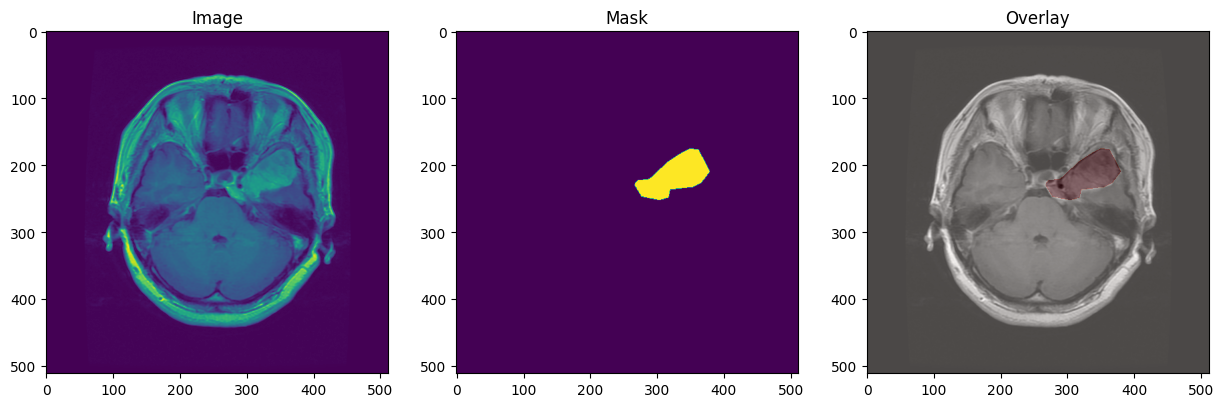

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(img_list[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(msk_list[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(img_list[0], cmap='gray')
plt.imshow(msk_list[0], cmap='Reds', alpha=0.3)

#### 1.2.3. 데이터셋 전처리

In [8]:
img_size = (200, 200) # 이미지 사이즈 정규화
num_classes = 1 # 레이블 종류 (tumor 1개)

# 이미지 전처리
resized_imgs = [skit.resize(img, img_size, anti_aliasing=True) for img in img_list] # 이미지 크기 리사이징
img_arrays = np.expand_dims(np.array(resized_imgs, dtype=np.float32), axis=-1) # 이미지를 array로 변환
input_imgs = (img_arrays - np.min(img_arrays))/(np.max(img_arrays)-np.min(img_arrays)) # 이미지 정규화 (0~1)

# 마스크 전처리
resized_msks = [skit.resize(msk, img_size) for msk in msk_list] # 이미지 크기 리사이징
msk_arrays = np.expand_dims(np.array(resized_msks), axis=-1) # 마스크를 array로 변환
targets = np.where(msk_arrays > 0, 1, 0) # 레이블 형태(0,1)로 변환
targets = targets.astype(np.uint8)

# 이미지 정보
print('입력 어레이 크기 = ', input_imgs.shape)
print(f'입력 어레이 최대값/최소값 = {np.max(input_imgs)}/{np.min(input_imgs)}')
# 마스크 정보
print('타겟 어레이 크기 = ', targets.shape)
print(f'타켓 어레이 최대값/최소값 = {np.max(targets)}/{np.min(targets)}')

입력 어레이 크기 =  (1000, 200, 200, 1)
입력 어레이 최대값/최소값 = 1.0/0.0
타겟 어레이 크기 =  (1000, 200, 200, 1)
타켓 어레이 최대값/최소값 = 1/0


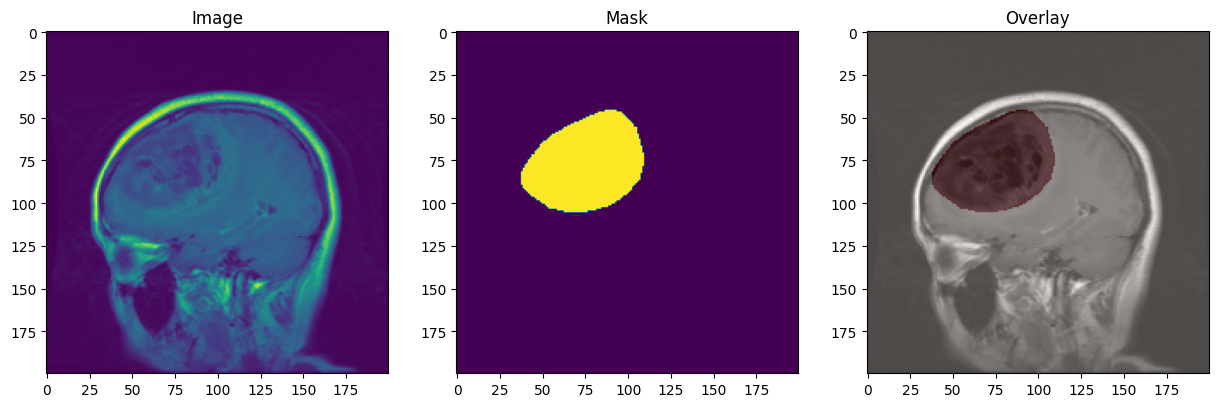

In [9]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# 검증 데이터셋 확인
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(val_input_imgs[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(val_targets[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(val_input_imgs[0], cmap='gray')
plt.imshow(val_targets[0], cmap='Reds', alpha=0.3)

### 1.3. 학습 준비

#### 1.3.1. 텐서 준비

In [10]:
class BrainDataset(Dataset):
    def __init__(self, img_list, lab_list, resize=200):
        self.img_list = img_list
        self.lab_list = lab_list
        self.resize = (resize, resize)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        lab_path = self.lab_list[idx]
        img_arr = skio.imread(img_path)
        lab_arr = skio.imread(lab_path)

        # 이미지 전처리
        input_arr = skit.resize(img_arr, self.resize, anti_aliasing=True) # 이미지 크기 리사이징
        input_arr = np.expand_dims(np.array(input_arr), axis=0) # 이미지를 tensor로 변환
        input_arr = (input_arr - np.min(input_arr))/(np.max(input_arr)-np.min(input_arr)) # 이미지 정규화 (0~1)
        input_tensor = torch.tensor(input_arr, dtype=torch.float32)

        # 마스크 전처리
        output_arr = skit.resize(lab_arr, self.resize) # 이미지 크기 리사이징
        output_arr = np.expand_dims(np.array(output_arr), axis=0) # 마스크를 tensor로 변환
        output_arr = np.where(output_arr > 0, 1, 0) # 레이블 형태(0,1)로 변환
        output_tensor = torch.tensor(output_arr, dtype=torch.float32)

        return input_tensor, output_tensor

In [11]:
# 검증 데이터셋 분할
img_fol_path = './brain_seg_2d/images'
msk_fol_path = './brain_seg_2d/masks'
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
img_file_list = [os.path.join(img_fol_path, i) for i in sorted(os.listdir(img_fol_path))]
msk_file_list = [os.path.join(msk_fol_path, i) for i in sorted(os.listdir(msk_fol_path))]
train_images = img_file_list[:-num_val_samples]
train_labels = msk_file_list[:-num_val_samples]
test_images = img_file_list[-num_val_samples:]
test_labels = msk_file_list[-num_val_samples:]
print(f'Train Number = ({len(train_images)}/{len(train_labels)})')
print(f'Validation Number = ({len(test_images)}/{len(test_labels)})')

Train Number = (900/900)
Validation Number = (100/100)


In [12]:
brain_train = BrainDataset(train_images, train_labels, resize=256)
brain_test = BrainDataset(test_images, test_labels, resize=256)

# 데이터셋 확인 (torch tensor)
print(brain_train.__len__())
print(brain_train.__getitem__(0)[0].size(), brain_train.__len__())
print(brain_test.__getitem__(0)[0].size(), brain_test.__len__())

900
torch.Size([1, 256, 256]) 900
torch.Size([1, 256, 256]) 100


torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


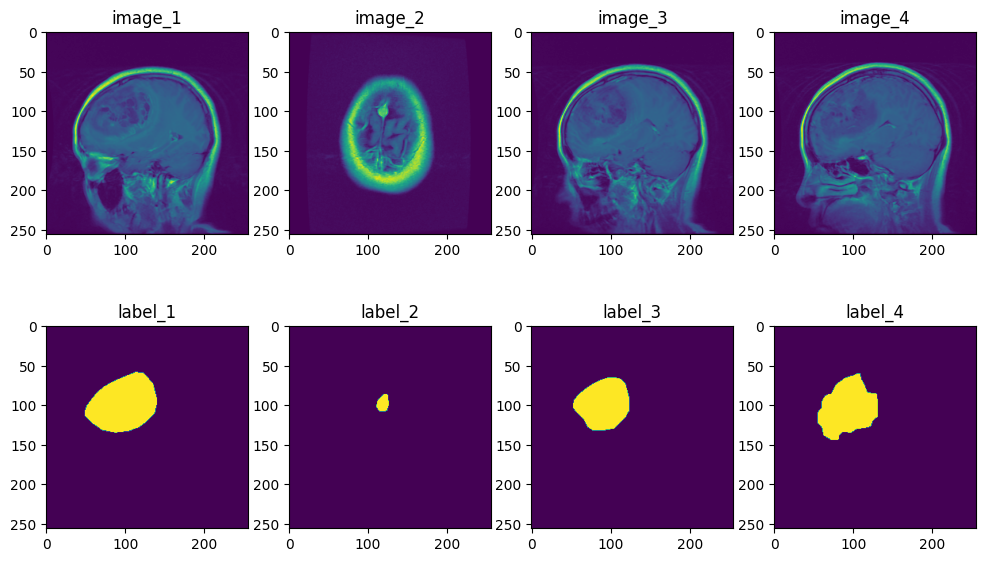

In [13]:
print(brain_test[0][0].size()) # 0번째 프레임의 이미지 크기 출력
print(brain_test[0][1].size()) # 0번째 프레임의 레이블 크기 출력
plt.figure(figsize=(12,7))
for i in range(4): # 4개의 데이터 추가 확인
    plt.subplot(2,4,i+1)
    plt.imshow(np.moveaxis(brain_test[i][0].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'image_{i+1}')
    plt.subplot(2,4,i+5)
    plt.imshow(np.moveaxis(brain_test[i][1].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'label_{i+1}')

#### 1.4. 모델 준비

In [14]:
# 자주 쓰는 연산들과 항상 세트로 쓰는 연산들은 편의를 위해 함수로 정의해 놓습니다.

def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

In [15]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Sigmoid(),  #필수는 아님
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)


        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [16]:
batch_size = 16
img_size = 256
in_dim = 1
out_dim = 1
num_filters = 32

train_loader = DataLoader(brain_train, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader = DataLoader(brain_test, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)

In [17]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)

# 손실함수로는 Binary Cross-Entropy Loss를 사용합니다.
loss_func = nn.BCEWithLogitsLoss()

# 평가 지표로는 DIce score를 사용합니다.
def dice_score(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice

# 손실함수로는 Binary Cross-Entropy Loss를 사용합니다.
def dice_loss(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return 1-dice
# loss_func = nn.BCEWithLogitsLoss()

# 최적화함수로는 Adam을 사용합니다.
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [18]:
summary(model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
         LeakyReLU-3         [-1, 32, 256, 256]               0
         LeakyReLU-4         [-1, 32, 256, 256]               0
         LeakyReLU-5         [-1, 32, 256, 256]               0
         LeakyReLU-6         [-1, 32, 256, 256]               0
         LeakyReLU-7         [-1, 32, 256, 256]               0
         LeakyReLU-8         [-1, 32, 256, 256]               0
         LeakyReLU-9         [-1, 32, 256, 256]               0
        LeakyReLU-10         [-1, 32, 256, 256]               0
        LeakyReLU-11         [-1, 32, 256, 256]               0
        LeakyReLU-12         [-1, 32, 256, 256]               0
        LeakyReLU-13         [-1, 32, 256, 256]               0
        LeakyReLU-14         [-1, 32, 2

### 1.4. 모델 학습

In [19]:
# 학습 모듈
def train(dataloader, model, loss_fn, metric_fn, optimizer, epoch, ):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batches)
    train_loss, train_met = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)
        metric = metric_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Epoch result
        train_loss += loss.item()
        train_met += metric.item()

        # Traing Process check
        loss, metric, current = loss.item(), metric.item(), (batch + 1) * len(x)
        pbar.set_description(f" - Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}, dice = {metric:>0.3f}")
        pbar.update(1)
    pbar.close()
    # epoch
    train_loss /= num_batches
    train_met /= num_batches
    return train_loss, train_met

In [20]:
# 검증 모듈
def test(dataloader, model, loss_fn, metric_fn, epoch, show=False):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_met = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            test_met += metric_fn(pred, y).item()
    test_loss /= num_batches
    test_met /= num_batches
    if show:
        print(f"    = Validation[{epoch}]: val_loss = {test_loss:>5f}, val_dice: {(test_met):>0.3f}%")
    return test_loss, test_met

In [21]:
num_epoch = 10

best_model = None
best_loss = float('inf')

history = {'loss': [], 'val_loss': [], 'dice': [], 'val_dice': []}
for t in range(num_epoch):
    train_loss, train_met = train(train_loader, model, dice_loss, dice_score, optimizer, t+1)
    val_loss, val_met = test(test_loader, model, dice_loss, dice_score, t+1)

    # Best Validation loss save
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['dice'].append(train_met)
    history['val_dice'].append(val_met)
    print(f'# Training[{t+1}/{num_epoch}]: loss = {train_loss:>5f}, dice = {train_met:>0.3f}, val_loss = {val_loss:5>f}, val_dice = {val_met:>0.3f}')

torch.save(best_model, 'best_model.h5')

 - Batch Training[1](896/900): loss = 0.860911, dice = 0.139: 100%|██████████| 56/56 [00:20<00:00,  2.68it/s]


# Training[1/10]: loss = 0.899009, dice = 0.101, val_loss = 0.940886, val_dice = 0.059


 - Batch Training[2](896/900): loss = 0.835515, dice = 0.164: 100%|██████████| 56/56 [00:20<00:00,  2.74it/s]


# Training[2/10]: loss = 0.843835, dice = 0.156, val_loss = 0.923389, val_dice = 0.077


 - Batch Training[3](896/900): loss = 0.814477, dice = 0.186: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s]


# Training[3/10]: loss = 0.790348, dice = 0.210, val_loss = 0.890124, val_dice = 0.110


 - Batch Training[4](896/900): loss = 0.751437, dice = 0.249: 100%|██████████| 56/56 [00:22<00:00,  2.52it/s]


# Training[4/10]: loss = 0.734251, dice = 0.266, val_loss = 0.921933, val_dice = 0.078


 - Batch Training[5](896/900): loss = 0.624252, dice = 0.376: 100%|██████████| 56/56 [00:22<00:00,  2.52it/s]


# Training[5/10]: loss = 0.676070, dice = 0.324, val_loss = 0.859557, val_dice = 0.140


 - Batch Training[6](896/900): loss = 0.543438, dice = 0.457: 100%|██████████| 56/56 [00:21<00:00,  2.64it/s]


# Training[6/10]: loss = 0.601999, dice = 0.398, val_loss = 0.902743, val_dice = 0.097


 - Batch Training[7](896/900): loss = 0.421511, dice = 0.578: 100%|██████████| 56/56 [00:21<00:00,  2.62it/s]


# Training[7/10]: loss = 0.523348, dice = 0.477, val_loss = 0.857364, val_dice = 0.143


 - Batch Training[8](896/900): loss = 0.399283, dice = 0.601: 100%|██████████| 56/56 [00:21<00:00,  2.60it/s]


# Training[8/10]: loss = 0.432715, dice = 0.567, val_loss = 0.699797, val_dice = 0.300


 - Batch Training[9](896/900): loss = 0.427324, dice = 0.573: 100%|██████████| 56/56 [00:21<00:00,  2.64it/s]


# Training[9/10]: loss = 0.362667, dice = 0.637, val_loss = 0.764761, val_dice = 0.235


 - Batch Training[10](896/900): loss = 0.308099, dice = 0.692: 100%|██████████| 56/56 [00:21<00:00,  2.65it/s]


# Training[10/10]: loss = 0.306359, dice = 0.694, val_loss = 0.875562, val_dice = 0.124


### 1.5. 결과 확인

In [22]:
for key in history.keys():
    print(key, history[key])

loss [0.8990085082394736, 0.8438351558787482, 0.7903483286499977, 0.734250837138721, 0.6760702537638801, 0.6019994382347379, 0.5233483857342175, 0.4327147262437003, 0.36266717527593884, 0.30635943583079744]
val_loss [0.9408862690130869, 0.9233886202176412, 0.8901240428288778, 0.9219327668348948, 0.8595572412014008, 0.9027427633603414, 0.8573640584945679, 0.6997969051202139, 0.7647613286972046, 0.8755619525909424]
dice [0.1009914909622499, 0.15616484385515964, 0.20965167347873961, 0.2657491665865694, 0.323929744639567, 0.39800055963652475, 0.47665161533015116, 0.5672852737562997, 0.6373328247240612, 0.6936405641692025]
val_dice [0.05911372664074103, 0.07661138474941254, 0.10987596275905769, 0.07806724247833093, 0.14044276624917984, 0.09725723539789517, 0.14263595889012018, 0.3002030899127324, 0.23523865888516107, 0.12443804554641247]


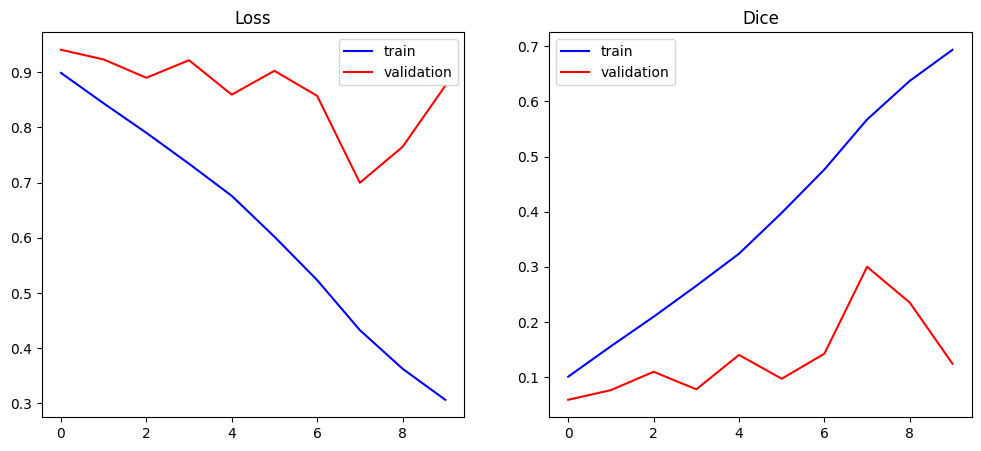

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], c='b', label='train')
plt.plot(history['val_loss'], c='r', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Dice')
plt.plot(history['dice'], c='b', label='train')
plt.plot(history['val_dice'], c='r', label='validation')
plt.legend()

In [24]:
# 저장된 모델 불러오기
model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)
model.load_state_dict(torch.load('./best_model.h5'))
model.eval()

UnetGenerator(
  (down_1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_2): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_2): Max

In [25]:
pred_list = []
with torch.no_grad():
    for img, lab in test_loader:
        x = img.to(device)
        pred = model.forward(x)
        for i in range(len(x)):
            probs = pred[i].cpu().detach().numpy()
            pred_list.append(probs)
print(pred_list[0].shape)
print(len(pred_list))

(1, 256, 256)
96


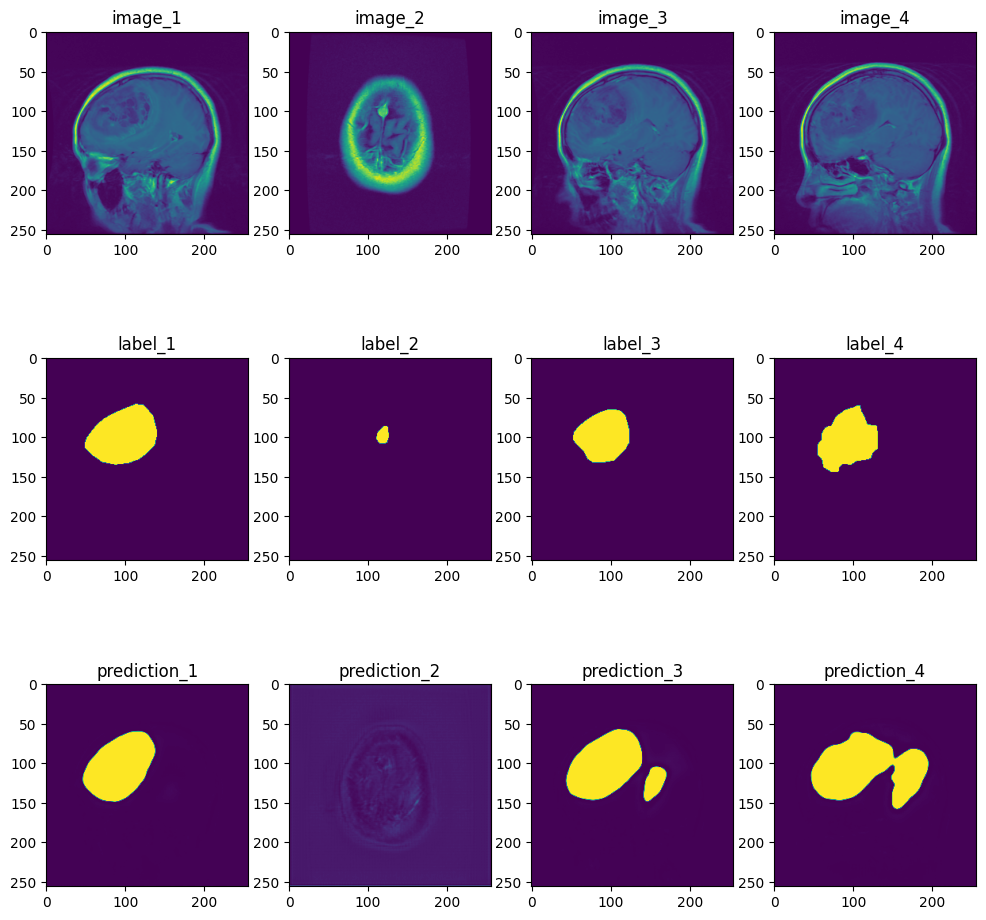

In [26]:
plt.figure(figsize=(12,12))
for i in range(4):
    img = np.moveaxis(brain_test[i][0].detach().numpy(), 0 , -1)
    label = np.moveaxis(brain_test[i][1].detach().numpy(), 0 , -1)
    pred = np.moveaxis(pred_list[i], 0 , -1)
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f'image_{i+1}')
    plt.subplot(3,4,i+5)
    plt.imshow(label)
    plt.title(f'label_{i+1}')
    plt.subplot(3,4,i+9)
    plt.imshow(pred)
    plt.title(f'prediction_{i+1}')

Text(0.5, 1.0, 'Comparison')

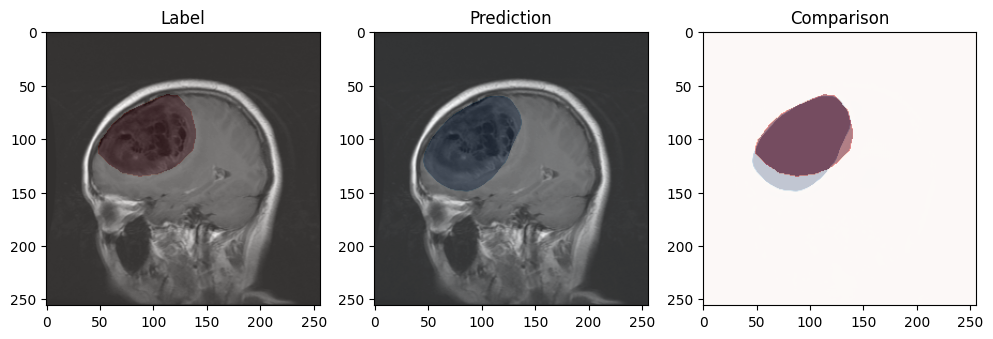

In [27]:
n = 0
img = np.moveaxis(brain_test[n][0].detach().numpy(), 0 , -1)
label = np.moveaxis(brain_test[n][1].detach().numpy(), 0 , -1)
pred = np.moveaxis(pred_list[n], 0 , -1)
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.imshow(label, cmap='Reds', alpha=0.2)
plt.title('Label')
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.imshow(pred, cmap='Blues', alpha=0.2)
plt.title('Prediction')
plt.subplot(133)
plt.imshow(pred, cmap='Blues', alpha=0.5)
plt.imshow(label, cmap='Reds', alpha=0.5)
plt.title('Comparison')

Text(0.5, 1.0, 'Comparison')

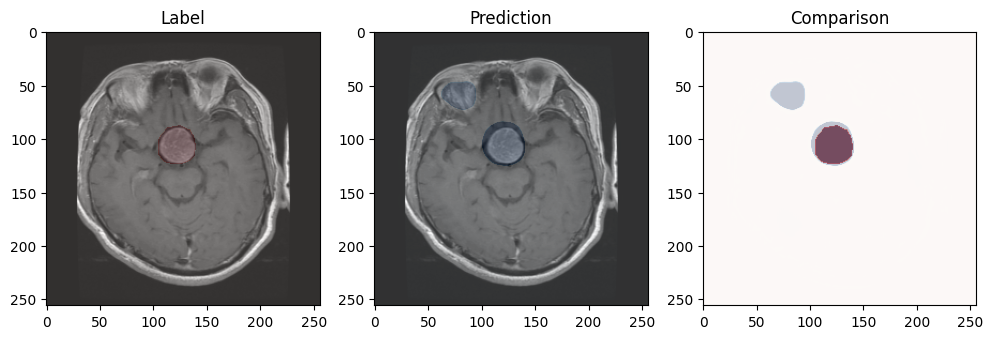

In [29]:
n = 30
img = np.moveaxis(brain_test[n][0].detach().numpy(), 0 , -1)
label = np.moveaxis(brain_test[n][1].detach().numpy(), 0 , -1)
pred = np.moveaxis(pred_list[n], 0 , -1)
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.imshow(label, cmap='Reds', alpha=0.2)
plt.title('Label')
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.imshow(pred, cmap='Blues', alpha=0.2)
plt.title('Prediction')
plt.subplot(133)
plt.imshow(pred, cmap='Blues', alpha=0.5)
plt.imshow(label, cmap='Reds', alpha=0.5)
plt.title('Comparison')